We want to time...

* gradient computation
* Simple arithmetic
* Linear algebra operations
* Functional primitives (sin, exp, etc) 

In [1]:
from speed_tests import PyTorch, NumPy
from functools import lru_cache

In [2]:
import numpy as np
import time
import numpy.linalg as LA
import torch
import timeit
from warnings import warn

def time_fn(fn_name, class_, limit=1):
    times = []
    f = getattr(class_, fn_name)
    start_time = time.time()
    while True:
        start = time.time()
        r = f()
        end = time.time()
        times += [end - start]
        if time.time() - start_time > limit:
            break
        
    return {'result': r,
            'time': min(times),
            'repeats': len(times)}

def get_numpy_array(in_):
    if type(in_) == np.ndarray:
        return in_
    if type(in_) == torch.DoubleTensor: 
        return in_.numpy()
    if type(in_) == torch.autograd.Variable:
        if len(in_.data) > 1:
            warn('len(in_.data) > 1. Concat\'ing data')
            return in_.data[:].numpy()
        return in_.data[0].numpy()
    if type(ret) != np.ndarray:
        raise ValueError(f'{type(result)} != np.ndarray')

def compare_fns(fn_name, *classes, verbose=True):
    assert len(classes) == 2
    
    data = [time_fn(fn_name, c) for i, c in enumerate(classes)]
    times = [{key: datum[key] for key in ['time']}#, 'std']}
             for c, datum in zip(classes, data)]
    results = [get_numpy_array(datum['result']) for datum in data]
            
    if verbose:
        error = np.abs(results[0] - results[1])
        rel_error = LA.norm(results[0] - results[1]) / LA.norm(results[0])
        print('error.mean =', error.mean(), 'relative error =', rel_error)
        
    assert np.allclose(*results)
    
    for i, datum in enumerate(data):
        del data[i]['result']
    
    return data
    

In [3]:
numpy = NumPy(int(2e3))
pytorch = PyTorch(A=numpy.A, x=numpy.x, y=numpy.y, S=numpy.S, S_svd=numpy.S_svd)

numpy.__name__ = 'numpy'
pytorch.__name__ = 'pytorch'
fns = [f for f in dir(numpy) if f[0] != '_' and f != f.upper() and len(f) != 1 and f != 'S_svd']
fns

['add', 'complex_fn', 'cumsum', 'grad', 'matmul', 'pow', 'sin', 'svd']

In [4]:
data = []
for fn in fns:
    print(fn)
    t_np, t_pyt = compare_fns(fn, numpy, pytorch)
    
    data += [{'function': fn,
              'numpy_time': t_np['time'], 'pytorch_time': t_pyt['time']}]
    print(data[-1])

add
error.mean = 0.0 relative error = 0.0
{'function': 'add', 'numpy_time': 0.18988633155822754, 'pytorch_time': 0.16830110549926758}
complex_fn
error.mean = 1.15027859819e+38 relative error = 4.63929025871e-19
{'function': 'complex_fn', 'numpy_time': 0.0051081180572509766, 'pytorch_time': 0.005244016647338867}
cumsum
error.mean = 0.0 relative error = 0.0
{'function': 'cumsum', 'numpy_time': 1.413053035736084, 'pytorch_time': 1.28731107711792}
grad


/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:31: UserWarning: len(in_.data) > 1. Concat'ing data


error.mean = 4.59026921431e-16 relative error = 4.17322888086e-14
{'function': 'grad', 'numpy_time': 0.23931217193603516, 'pytorch_time': 0.03609180450439453}
matmul
error.mean = 3.12322168128e-14 relative error = 9.25778878186e-16
{'function': 'matmul', 'numpy_time': 0.01742696762084961, 'pytorch_time': 0.01739025115966797}
pow
error.mean = 0.0 relative error = 0.0
{'function': 'pow', 'numpy_time': 4.57763671875e-05, 'pytorch_time': 4.673004150390625e-05}
sin
error.mean = 0.0 relative error = 0.0
{'function': 'sin', 'numpy_time': 0.722559928894043, 'pytorch_time': 0.719749927520752}
svd
error.mean = 2.86063707444e-14 relative error = 2.28221959828e-15
{'function': 'svd', 'numpy_time': 0.08397579193115234, 'pytorch_time': 0.08576488494873047}


In [5]:
from altair import Chart
import pandas as pd
df = pd.DataFrame(data)
df.index = df.function
df

,function,numpy_time,pytorch_time
function,,,
add,add,0.189886,0.168301
complex_fn,complex_fn,0.005108,0.005244
cumsum,cumsum,1.413053,1.287311
grad,grad,0.239312,0.036092
matmul,matmul,0.017427,0.017390
pow,pow,0.000046,0.000047
sin,sin,0.722560,0.719750
svd,svd,0.083976,0.085765


In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df['pytorch_time_norm'] = df['pytorch_time'] / df['numpy_time']
df['numpy_time_norm'] = df['numpy_time'] /   df['numpy_time']
df['pytorch_speedup'] = df['numpy_time'] /   df['pytorch_time']

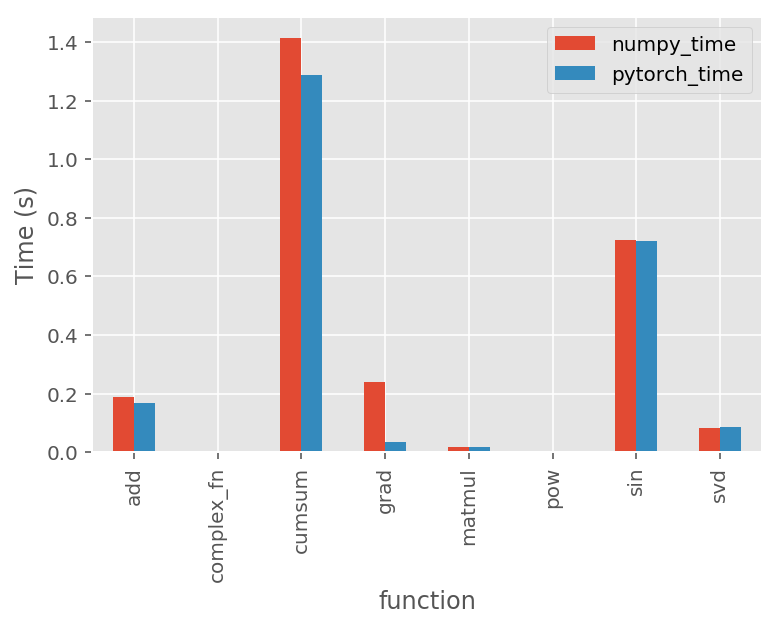

In [7]:
df.plot.bar(x='function', y=['numpy_time', 'pytorch_time'],
#             yerr=[df['numpy_time_std'], df['pytorch_time_std']],
            logy=False)
plt.ylabel('Time (s)')

(0, 1.4)

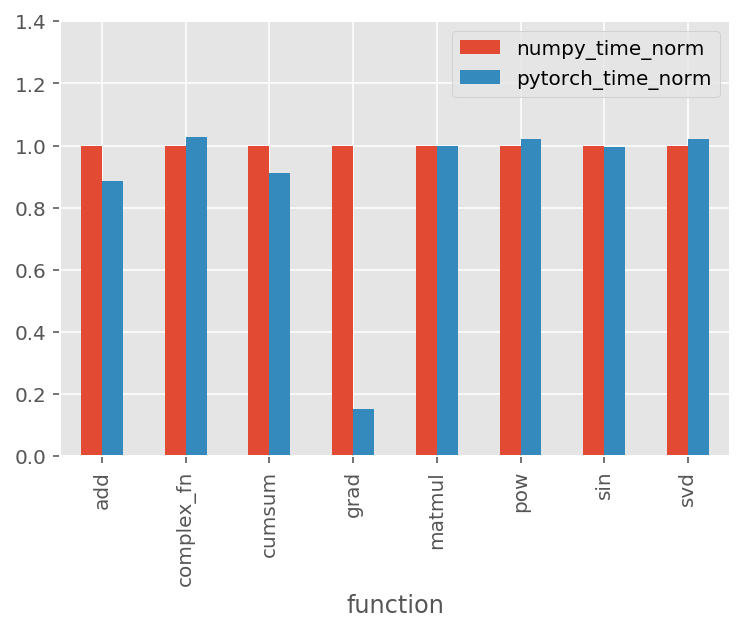

In [10]:
df.plot.bar(x='function', y=['numpy_time_norm', 'pytorch_time_norm'])
plt.ylim(0, 1.4)

In [12]:
df

,function,numpy_time,pytorch_time,pytorch_time_norm,numpy_time_norm,pytorch_speedup
function,,,,,,
add,add,0.189886,0.168301,0.886326,1.0,1.128254
complex_fn,complex_fn,0.005108,0.005244,1.026604,1.0,0.974085
cumsum,cumsum,1.413053,1.287311,0.911014,1.0,1.097678
grad,grad,0.239312,0.036092,0.150815,1.0,6.630651
matmul,matmul,0.017427,0.017390,0.997893,1.0,1.002111
pow,pow,0.000046,0.000047,1.020833,1.0,0.979592
sin,sin,0.722560,0.719750,0.996111,1.0,1.003904
svd,svd,0.083976,0.085765,1.021305,1.0,0.979140


In [15]:
df.index

Index(['add', 'complex_fn', 'cumsum', 'grad', 'matmul', 'pow', 'sin', 'svd'], dtype='object', name='function')

In [31]:
grad_times = df[df.function == 'grad'].T
grad_times

function,grad
function,grad
numpy_time,0.239312
pytorch_time,0.0360918
pytorch_time_norm,0.150815
numpy_time_norm,1
pytorch_speedup,6.63065
